# motion segmentation with spatial transform

## dataset
- FBMS (only part of ground true)
- BMS (video format, not very good)
- DAVIS (not motion segmentation, but main motion object segmentation)
- CamouflagedAnimalDataset (not spatial transform)
- complexBackground-multilabel (not spatial transform)
- changedetection2012/2014 (not spatial transform)

In [1]:
import os
import glob
import torch.utils.data as td
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

project_dir=os.path.expanduser('~/git/torchseg')
os.chdir(project_dir)

from dataset.fbms_dataset import fbms_dataset
from dataset.cdnet_dataset import cdnet_dataset
from models.motion_stn import motion_stn,motion_net
from models.motionseg.motion_fcn import motion_fcn,motion_fcn_stn
from models.motionseg.motion_unet import motion_unet,motion_unet_stn
from dataset.dataset_generalize import image_normalizations
from utils.augmentor import Augmentations
from utils.torch_tools import get_ckpt_path,load_ckpt
from utils.disc_tools import show_images, show_tensor_list
import argparse
from models.motionseg.motion_utils import get_parser,get_default_config

In [2]:
def get_model_and_dataset(config_list):
    parser=get_parser()
    args = parser.parse_args(config_list)

    config=get_default_config()

    if args.net_name=='motion_psp':
        if args.use_none_layer is False or args.upsample_layer<=3:
            min_size=30*config.psp_scale*2**config.upsample_layer
        else:
            min_size=30*config.psp_scale*2**3

        config.input_shape=[min_size,min_size]

    for key in config.keys():
        if hasattr(args,key):
            print('{} = {} (default: {})'.format(key,args.__dict__[key],config[key]))
            config[key]=args.__dict__[key]
        else:
            print('{} : (default:{})'.format(key,config[key]))

    for key in args.__dict__.keys():
        if key not in config.keys():
            print('{} : unused keys {}'.format(key,args.__dict__[key]))

    if args.dataset=='FBMS':
        config['train_path']='dataset/FBMS/Trainingset'
        config['test_path']=config['val_path']='dataset/FBMS/Testset'
    elif args.dataset=='cdnet2014':
        config['root_path']='dataset/cdnet2014'
    else:
        assert False

    if config['net_name'] in ['motion_stn','motion_net']:
        model=globals()[config['net_name']]() 
    else:
        model=globals()[config['net_name']](config)

    # support for cpu/gpu
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    normer=image_normalizations(ways='-1,1')
    augmentations = Augmentations()
    dataset_loaders={}
    for split in ['train','val']:
        if args.dataset=='FBMS':
            xxx_dataset=fbms_dataset(config,split,normalizations=normer,augmentations=augmentations)
        else:
            xxx_dataset=cdnet_dataset(config,split,normalizations=normer,augmentations=augmentations)

        xxx_loader=td.DataLoader(dataset=xxx_dataset,batch_size=args.batch_size,shuffle=True,drop_last=False,num_workers=2)
        dataset_loaders[split]=xxx_loader

    log_dir = os.path.join(config['log_dir'], config['net_name'],
                           config['dataset'], config['note'])
    checkpoint_path = get_ckpt_path(log_dir)
    model=load_ckpt(model,checkpoint_path)
    
    return model,dataset_loaders,normer

input_shape : (default:[224, 224])
backbone_name = vgg11 (default: vgg11)
upsample_layer = 1 (default: 1)
deconv_layer = 5 (default: 5)
use_none_layer = False (default: False)
net_name = motion_unet_stn (default: motion_unet)
backbone_freeze : (default:False)
backbone_pretrained : (default:True)
freeze_layer = 0 (default: 1)
freeze_ratio : (default:0.0)
modify_resnet_head : (default:False)
layer_preference : (default:last)
merge_type : (default:concat)
use_part_number = 1000 (default: 1000)
ignore_outOfRoi = True (default: True)
dataset = cdnet2014 (default: cdnet2014)
frame_gap : (default:5)
log_dir : (default:/home/yzbx/tmp/logs/motion)
init_lr : (default:0.0001)
use_bn : (default:False)
use_dropout : (default:False)
use_bias : (default:True)
upsample_type : (default:bilinear)
note = times001_1 (default: test)
batch_size = 4 (default: 4)
epoch = 30 (default: 30)
app = train (default: train)
save_model = True (default: True)
stn_loss_weight = 1.0 (default: 1.0)
motion_loss_weight = 1.

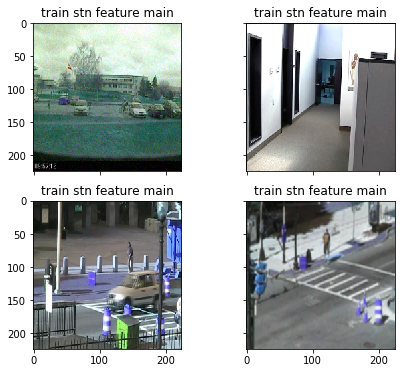

1 -0.03013544 0.51490444 1.0 -1.0


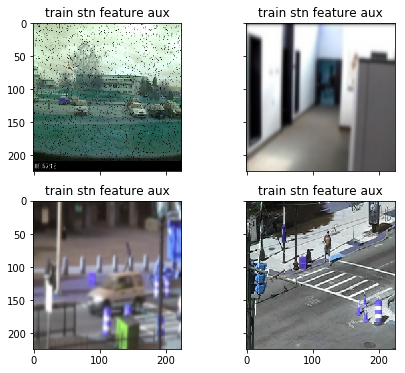

2 -0.020111645 0.58227605 0.91341984 -0.76950455


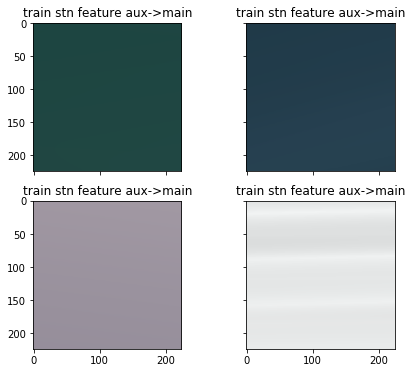

0 182.82573341836735 114.86456910011273 255 0


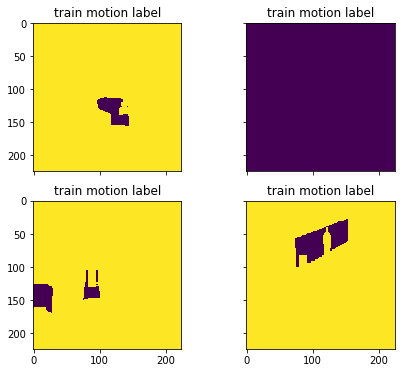

0 0.10919563137755102 0.3118845066136005 1 0


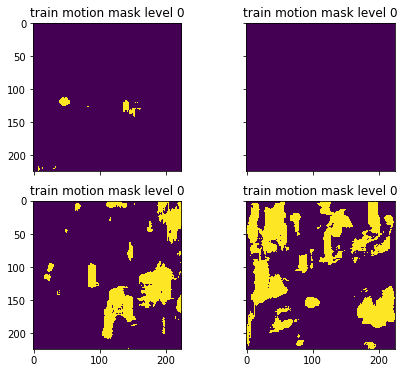

0 1.0 6.0297918e-09 1.0 0.99999994


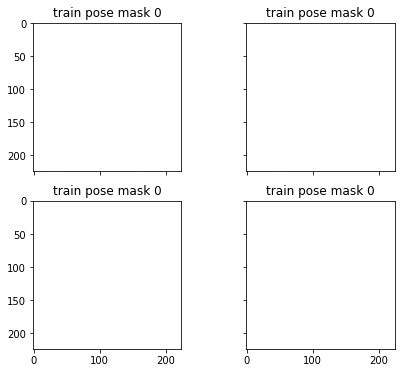

pose shape torch.Size([4, 1, 6])
theta tensor([[[ 0.0007, -0.0227,  0.0207],
         [-0.0000,  0.0108,  0.0084]],

        [[ 0.0000, -0.0243,  0.0187],
         [ 0.0008,  0.0121,  0.0116]],

        [[ 0.0005, -0.0207,  0.0227],
         [ 0.0000,  0.0102,  0.0088]],

        [[ 0.0025, -0.0170,  0.0186],
         [-0.0015,  0.0076,  0.0067]]],
       device='cuda:0', grad_fn=<ViewBackward>)
0 -0.07707319 0.41108695 1.0 -1.0


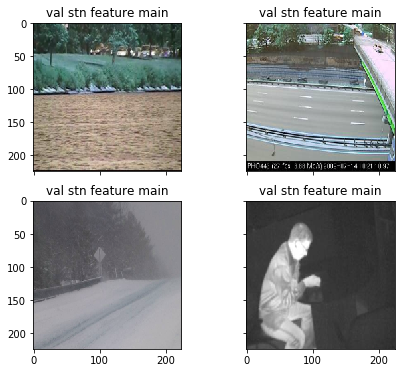

1 -0.07524596 0.4106998 1.0 -1.0


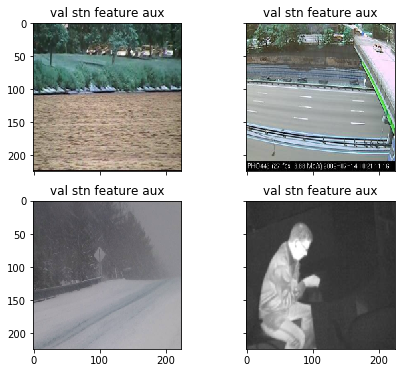

2 -0.036429342 0.35729584 0.44313726 -0.5311926


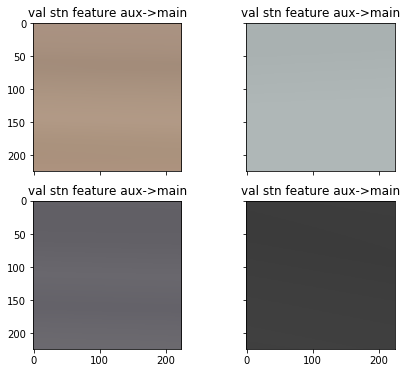

0 89.73530173788265 121.7133748428397 255 0


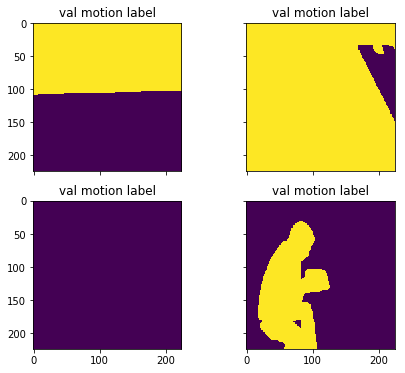

0 0.07972437021683673 0.27086600933001076 1 0


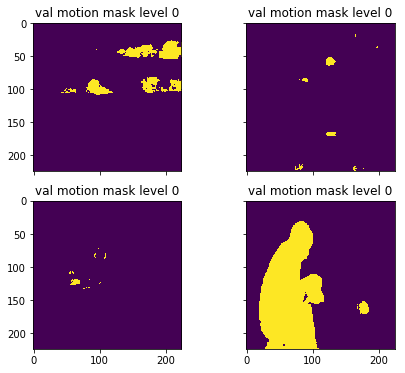

0 1.0 7.65333e-09 1.0 0.99999994


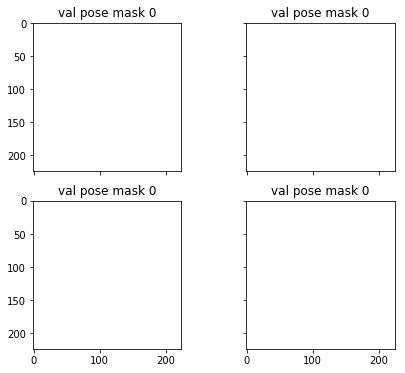

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f9801e8cd68>>
Traceback (most recent call last):
  File "/home/yzbx/bin/miniconda3/envs/new/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/yzbx/bin/miniconda3/envs/new/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/yzbx/bin/miniconda3/envs/new/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/yzbx/bin/miniconda3/envs/new/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/yzbx/bin/miniconda3/envs/new/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/yzbx/bin/minicond

In [3]:
def stn_loss(features,motion,pose,pose_mask_reg=1.0):
    n=len(features)
    total_loss=0
    for i in range(n-1):
        theta=pose[:,i,:].view(-1,2,3)
        grid=F.affine_grid(theta,features[i+1].size())
        pose_mask=F.grid_sample(torch.ones_like(features[i+1]),grid)
        
        print('grid shape',grid.shape)
#         loss=F.l1_loss(features[0],features[i+1],reduction='none')
#         loss=F.l1_loss(features[0],features[i+1],reduction='none')
        loss=torch.abs(features[0]-features[i+1])
        print('l1_loss shape',loss.shape)
        loss=torch.clamp(loss,min=0,max=2.0)
        print('l1_loss clamp shape',loss.shape)
        print('features[0] shape',features[0].shape)
        print('features[1] shape',features[1].shape)
        print('pose mask shape',pose_mask.shape)
        
        print('l1_loss',torch.mean(loss).item())
        print('feature 0',torch.mean(features[0]).item(),torch.max(features[0]).item(),torch.min(features[0]).item())
        print('feature 1',torch.mean(features[1]).item(),torch.max(features[1]).item(),torch.min(features[1]).item())
        total_loss+=torch.mean(loss*(1-motion)*pose_mask)
        print('total_loss',total_loss.item())
        pose_reg_loss=pose_mask_reg*torch.mean(1-pose_mask)
        print('pose_reg_loss',pose_reg_loss.item())
        total_loss+=pose_reg_loss
    return total_loss

config_list='--net_name motion_unet_stn --backbone_name vgg11'
config_list+=' --upsample_layer 1 --freeze_layer 0 --deconv_layer 5 --use_none_layer False'
config_list+=' --use_part_number 1000 --note times001_1 --dataset cdnet2014'
model,dataset_loaders,normer=get_model_and_dataset(config_list.split())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
for split in ['train','val']:
    for frames,gt in dataset_loaders[split]:
        images = [torch.autograd.Variable(img.to(device).float()) for img in frames]
        labels=torch.autograd.Variable(gt.to(device).long())
        outputs=model.forward(images)
#         stn_loss_value=stn_loss(outputs['stn_images'],labels.float(),outputs['pose'],config['pose_mask_reg'])
        
        pose=outputs['pose']
        print('pose shape',pose.shape)
        stn_features=[images[0],images[1]]
        pose_masks=[]
        n=len(images)
        for i in range(n-1):
            theta=pose[:,i,:].view(-1,2,3)
            print('theta',theta)
            grid=F.affine_grid(theta,images[i+1].size())
            aux_feature=F.grid_sample(images[i+1],grid)
            pose_mask=F.grid_sample(torch.ones_like(images[i+1]),grid)
            stn_features.append(aux_feature)
            pose_masks.append(pose_mask)
            
        image_list_title=['main','aux','aux->main']
        image_list_title=[split+' stn feature '+note for note in image_list_title]
        show_tensor_list(stn_features,image_list_title,normer)
        
        show_tensor_list([gt],[split+' motion label'])
        
        masks=[torch.argmax(x,dim=1,keepdim=True) for x in outputs['masks']]
        show_tensor_list(masks,[split+' motion mask level '+str(idx) for idx,t in enumerate(outputs['masks'])])
        
        show_tensor_list(pose_masks,[split+' pose mask ' +str(idx) for idx,t in enumerate(pose_masks)])

        break

In [ ]:
image_lists=[]
for idx,t in enumerate(stn_features):
    batch_images=t.data.cpu().numpy()
    batch_images=batch_images.transpose((0,2,3,1))
    batch_images=normer.backward(batch_images).astype(np.uint8)
    print(idx,np.mean(batch_images),np.std(batch_images))

    image_list=np.split(batch_images,4)
    image_list=[np.squeeze(img) for img in image_list]
    image_lists.append(image_list)

n=len(image_lists[0])
for idx in range(n):
    show_img_list=[image_lists[i][idx] for i in range(len(image_lists))]
    theta=pose[idx,0,:].view(2,3).data.cpu().numpy()
    aux_img=show_img_list[1]
    warp_img=cv2.warpAffine(aux_img,theta,aux_img.shape[0:2])
    show_img_list.append(warp_img)
    show_images(show_img_list,['main','aux','aux->main(pytorch)','aux->main(opencv)'])

In [4]:
print(dataset_loaders['train'].train_set)

AttributeError: 'DataLoader' object has no attribute 'train_set'